## ACTIVIDAD 2

## Contornos activos mediante el algoritmo Snake

###  Curso: Procesamiento, Análisis, Codificación y Seguridad de Imágenes Digitales

###   Profesor: Manuel Quispe

Primero, se va a importar las librerías necesarias para realizar el procesamiento de imágenes con Python, para este caso se utilizará numpy, matplotlib y openCV para la adquisición de imágenes. Además, se deja comentado la instrucción para la instalación de la librería openCV en caso no se cuente con ese paquete instalado. 

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

#!pip install opencv-python
import cv2

Ahora se procede a trabajar con la imagen siguiente, si bien esta imagen se usa por comodidad se puede llegar a este estado luego de aplicar técnicas de procesamiento de imágenes como umbralización, operaciones morfolóficas, etc.

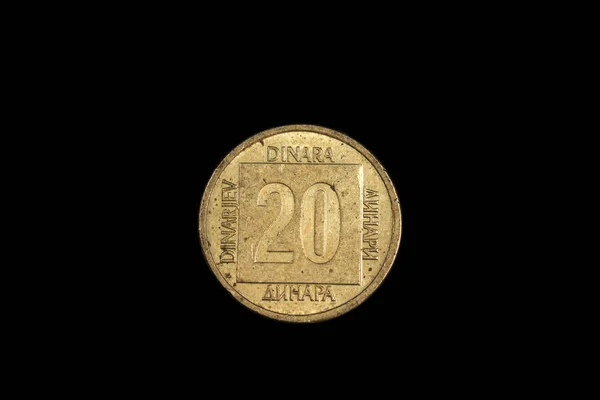

Se procede a leer la imagen con la ayuda de la librería openCV.

In [2]:
img = cv2.imread('moneda_20cent.jpg')

Debido a que openCV lee las imágenes en formato BGR, sin una debida conversión al espacio de color RGB la imagen podría adoptar un color indeseado.

In [3]:
imgRGB  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Ahora, se procede con la impresión en pantalla de la imagen adquirida.

### Imagen de la moneda en RGB

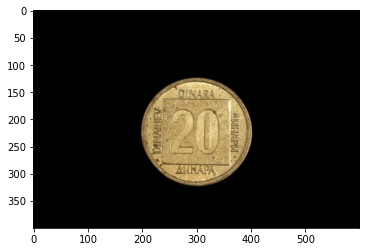

In [4]:
plt.imshow(imgRGB)

## Imagen de la moneda en escala de Grises

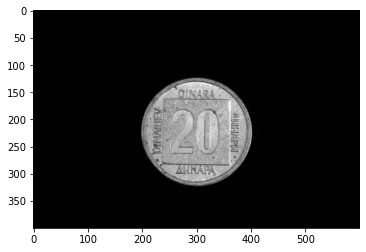

In [5]:
plt.imshow(imgGray,cmap="gray")

En este punto, ya se cuenta con las librerías e imagenes necesarias para iniciar con el procesamiento de imágenes.

## Se implementa una función de convolución.

Para continuar con el contorno activo es necesario declarar un filtro gaussiano y una funcion de gradiente (para este caso utilizaremos el algoritmo de sobel de 3x3).

In [6]:
def convolucion(imagen, filtro, borde):
    if  filtro == 'promedio':
        kernel = np.array([[1,1,1],[1,1,1],[1,1,1]])
        n = 9
        state = 0
    elif  filtro == 'gauss':
        kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])
        n = 16
        state = 0
    elif filtro == 'sobelX':
        kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        n = 1
        state = 0
    elif filtro == 'sobelY':
        kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
        n = 1
        state = 0
    elif filtro == 'sobelXY':
        state = 1

    else:
        print('Valor no reconocido')
        return -1
    
    # Hallamos la longitud y altura de la matriz imagen
    length = img.shape[0]
    height = img.shape[1]
    
    # Se selecciona el tipo de borde externo a la imagen
    if borde == 0:
        imgBorde = np.zeros((length+2, height+2))
    elif borde == 1:
        imgBorde = np.ones((length+2, height+2))
    
    # Aquí ya se cuenta con la imagen con el tipo de borde deseado (ceros o unos)
    imgBorde[1:1+length, 1:1+height] = imagen
    
    
    # Se inicializa la matriz resultante de la convolución con ceros
    result = np.zeros((length, height))
    
    if state == 0:
        for i in range(length):
            for j in range(height):
                # En 'aux' se calcula la convolución, se toma un trozo de 3x3 de la imagen con el borde seleccionado
                # y se multiplica elemento a elemento con el kernel (3x3), luego se suman los elementos resultantes y
                # se dividen entre el número n (también definido junto con cada kernel).
                aux = np.multiply(imgBorde[i:i+3,j:j+3], kernel)  
                aux = np.sum(aux)//n
                aux = np.abs(aux)
                result[i][j] = aux
                
    elif state == 1:
        aux = convolucion(imagen, 'sobelX', borde) + convolucion(imagen, 'sobelY', borde)
        result = aux
    
    return result

Además se crea una funcion de normalización de pixeles, ya que luego de la convolución puede resultar en valores que excedan la resolución de pixeles ( 0 - 255)

In [7]:
def normalizar(imagen):
    #Se normaliza los valores de la matriz resultante.
    maximum = np.amax(imagen)
    minimum = np.amin(imagen)
    aux = np.subtract(imagen, minimum)
    aux = np.multiply(aux,255)
    aux = np.divide(aux, maximum-minimum)
    aux = np.vectorize(int)(aux)
    
    return aux

### Se aplica la gradiente para hallar los bordes de la imagen

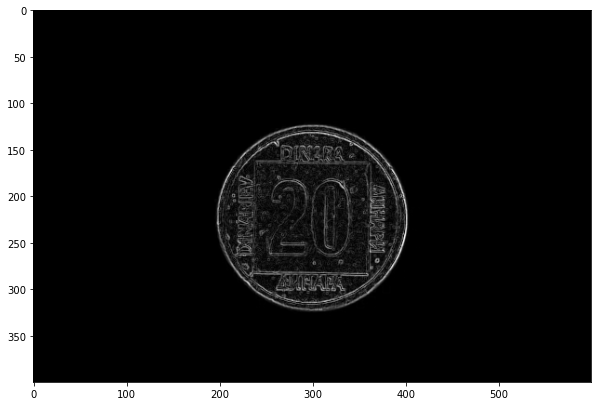

In [8]:
imgEdge = convolucion(imgGray,'sobelXY',0)
plt.figure(figsize=(10, 10))
plt.imshow(imgEdge,cmap="gray")

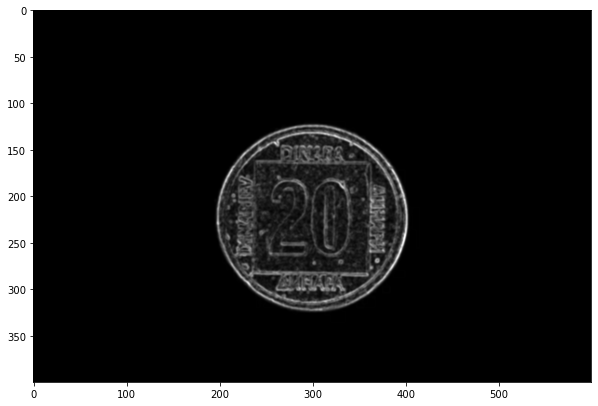

In [9]:
imgBlur = convolucion(imgEdge,'gauss',0)
plt.figure(figsize=(10, 10))
plt.imshow(imgBlur,cmap="gray")

#imgBlur = convolucion(imgGray,'gauss',0)
#plt.imshow(imgBlur,cmap="gray")

### Se aplica el filtro Gaussiano para difuminar la imagen

Se aplica más iteraciones del filtro gaussiano a con el objetivo de generar un cambio de intensidad de mayor área para que las gradientes sean de más facil detección.

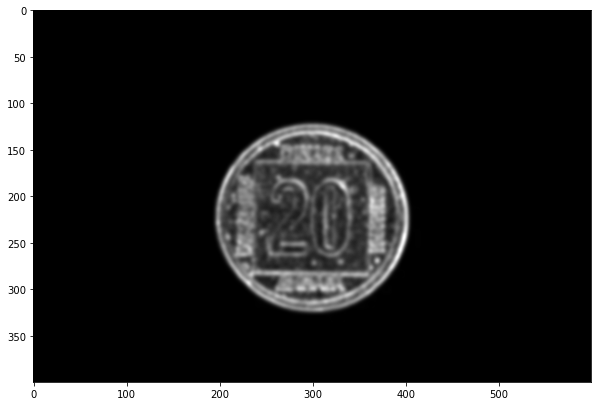

In [10]:
for i in range(20):
    aux = cv2.GaussianBlur(imgBlur,(11,11),0)
    #aux = cv2.GaussianBlur(aux,(11,11),0)

imgBlur = aux    
plt.figure(figsize=(10, 10))
plt.imshow(imgBlur,cmap="gray")

Se segmenta la imagen mediante umbrales:

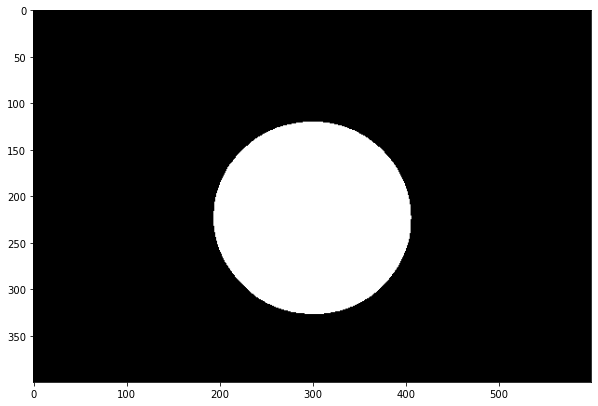

In [11]:
imgTresh = imgBlur > 30
plt.figure(figsize=(10, 10))
plt.imshow(imgTresh,cmap="gray")

Se realiza operaciones morfológicas para realizar una cerradura

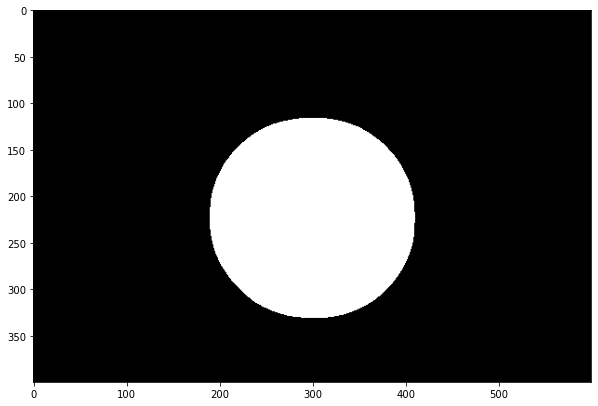

In [12]:
aux = imgTresh.astype('uint8')

# Se define el kernel
kernel = np.ones((9,9))

aux = cv2.dilate(aux,kernel,iterations = 7)
aux = cv2.erode(aux,kernel,iterations = 6)

imgMorph = aux
plt.figure(figsize=(10, 10))
plt.imshow(imgMorph, cmap = "gray")

Ahora se aplica la gradiente mediante una convolución con un kernel de Sobel de 3x3.

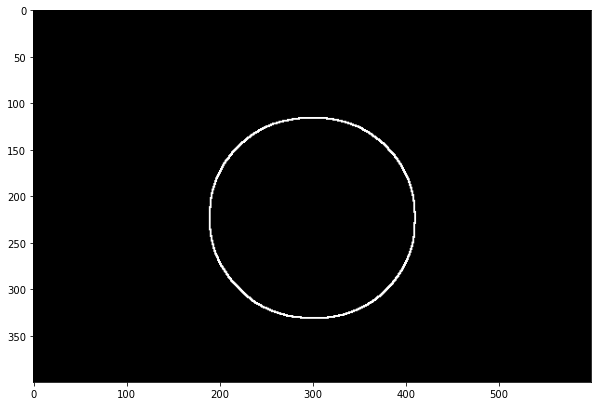

In [13]:
aux = convolucion(imgMorph,'sobelXY',0)

imgEdge = normalizar(aux)
imgEdge = (imgEdge > 0)*255

plt.figure(figsize=(10, 10))
plt.imshow(imgEdge,cmap="gray")

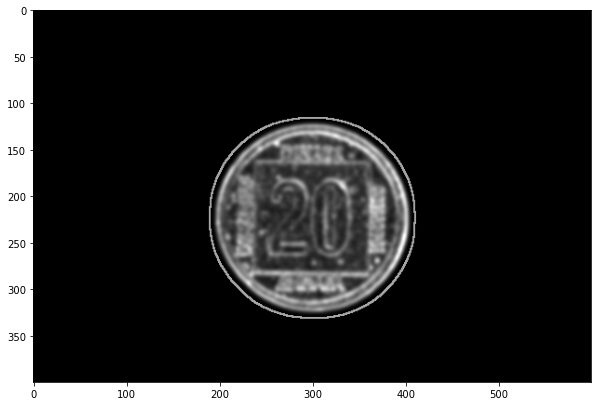

In [14]:
superpuesta = imgEdge + imgBlur

plt.figure(figsize=(10, 10))
plt.imshow(superpuesta, cmap = "gray")

Ahora se desarrolla un algoritmo que permita hallar las posiciones de los puntos del contorno inicial, al que llamaremos  V.

In [15]:
def posContorno(img):
    aux = np.transpose(np.where(img == 255))
    return aux               
    

In [16]:
v = posContorno(imgEdge)

En **v** se ha guardado las posiciones del contorno inicial, esta información es útil ya que aplicaremos la gradiente a cada punto del contorno, no así a toda la matriz.

In [17]:
def gradContorno(imgPiece):
    kernelX = np.array([[-1, -1, -2, -1, -1],\
                        [-2, -2, -4, -2, -2], \
                        [ 0,  0,  0,  0,  0], \
                        [ 2,  2,  4,  2,  2], \
                        [ 1,  1,  2,  1,  1]])  
    kernelY = np.array([[-2, -1,  0,  1,  2], \
                        [-2, -1,  0,  1,  2], \
                        [-4, -2,  0,  2,  4],\
                        [-2, -1,  0,  1,  2], \
                        [-2, -1,  0,  1,  2]])
    
    
    # Se calcula la gradiente en X
    gradX = np.multiply(imgPiece, kernelX)  
    gradX = np.sum(gradX)

    # Se calcula la gradiente en Y
    gradY = np.multiply(imgPiece, kernelY)  
    gradY = np.sum(gradY)
    
    distX = 0
    distY = 0
    
    if gradX > 0:
        dirX = 2
        distX = 1
    elif gradX < 0:
        dirX = -2
        distX = 1
    elif gradX == 0:
        dirX = 0
        dist = 0
    
    if gradY > 0:
        dirY = 2
        distY= 1
    elif gradY < 0:
        dirY = -2
        distY= 1 
    elif gradY== 0:
        dirY = 0
        distY= 0
        dist = 0
    
    distancia = distX+distY
    direccion = [dirX, dirY]
    
    return direccion, distancia


Ya definida la funcion gradiente con dirección y distancia se implementa el algoritmo de contorno.

In [18]:
newV = np.copy(v)
minMov = 2600
distancia =minMov;
iteracion = 0;

while iteracion < 5:#distancia >= minMov: 
    distancia = 0
    
    #Este algoritmo actualiza la lista de contornos v en newV
    for i in range (newV.shape[0]):
        j = newV[i][0]
        k = newV[i][1]
        dist = 0
        newPos = [0,0]
        if j >= 3 and j <= imgBlur.shape[0]-3 and k >= 3 and k <= imgBlur.shape[1]-3 : 
            aux = np.copy(imgBlur[j-2:j+3,k-2:k+3])
            newPos, dist = gradContorno(aux)
        
        newV[i] = newV[i] + newPos
        
        distancia = distancia + dist
        
    iteracion = iteracion + 1


In [19]:
print("iteración= ", iteracion, ", distancia= ", distancia)

iteración=  5 , distancia=  3488


Se desarrolla un algoritmo que dibuje las nuevas posiciones del contorno

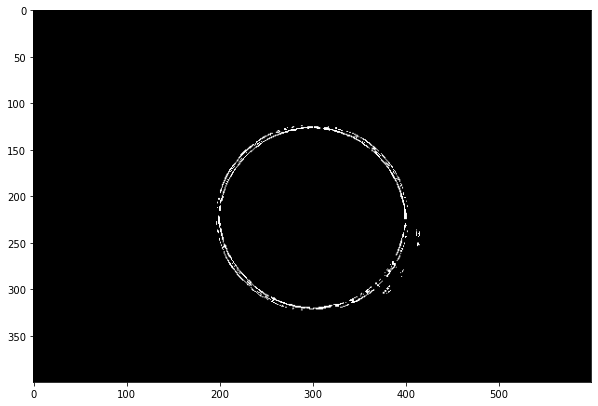

In [20]:
#Se crea la matriz de ceros del mismo tamaño que la imagen
newContour = np.zeros([imgGray.shape[0], imgGray.shape[1]])

for i in range(newV.shape[0]):    
    newContour[newV[i][0],newV[i][1]] = 255

plt.figure(figsize=(10, 10))
plt.imshow(newContour, cmap = "gray")

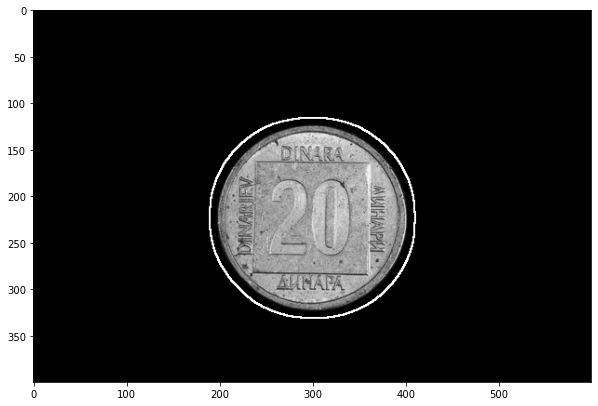

In [21]:
temp = imgGray + imgEdge
plt.figure(figsize=(10, 10))
plt.imshow(temp, cmap = "gray")

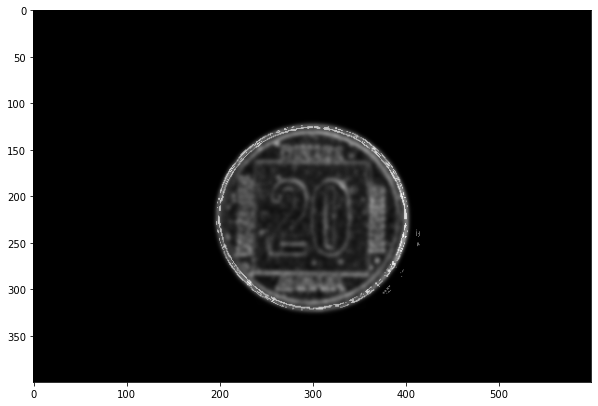

In [22]:
temp = imgBlur + newContour
plt.figure(figsize=(10, 10))
plt.imshow(temp, cmap = "gray")

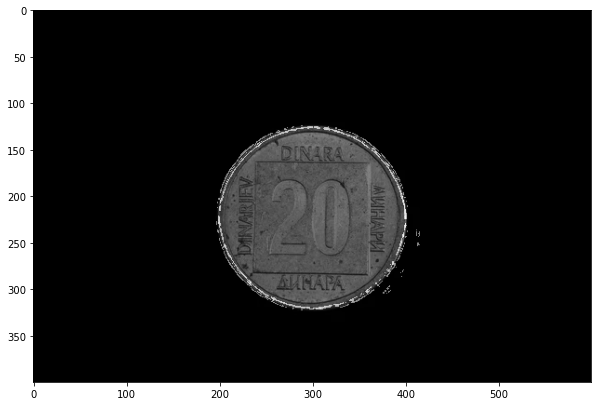

In [23]:
temp = imgGray + newContour
plt.figure(figsize=(10, 10))
plt.imshow(temp, cmap = "gray")